## 範例重點
* 學習如何在 keras 中加入 reduce learning rate
* 知道如何設定 reduce_lr 的監控目標
* 比較使用有無使用 reduce_lr 時的 performance

In [1]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

"""
建立神經網路，並加入 BN layer
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 20
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [7]:
"""
# 載入 Callbacks, 並設定監控目標為 validation loss
"""
from keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=5, 
                              verbose=1)

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[reduce_lr]
         )

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batc

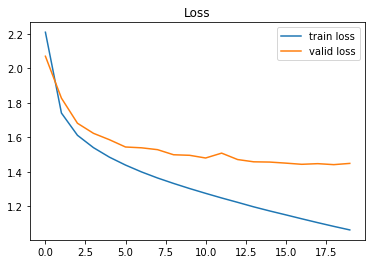

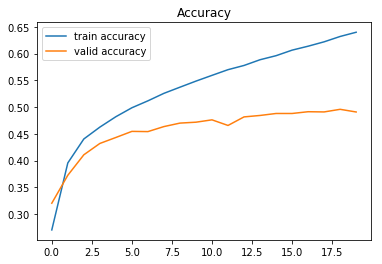

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [10]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [11]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.1,0.01,0.001,0.0001]
redice_lr_patient = [3,10,15]

In [ ]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=0.5, 
                              min_lr=reduce_factor, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

Numbers of exp: 0, reduce_factor: 0.10, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_4 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_5 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalizatio

50000/50000 [==============================] - 7s 139us/step - loss: 1.2249 - acc: 0.5777 - val_loss: 1.4920 - val_acc: 0.4790
Epoch 14/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.2006 - acc: 0.5853 - val_loss: 1.4753 - val_acc: 0.4820
Epoch 15/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.1758 - acc: 0.5953 - val_loss: 1.4784 - val_acc: 0.4846
Epoch 16/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.1500 - acc: 0.6061 - val_loss: 1.4631 - val_acc: 0.4894
Epoch 17/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.1280 - acc: 0.6151 - val_loss: 1.4701 - val_acc: 0.4883
Epoch 18/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.1061 - acc: 0.6220 - val_loss: 1.4625 - val_acc: 0.4882
Epoch 19/25
50000/50000 [==============================] - 8s 161us/step - loss: 1.0829 - acc: 0.6308 - val_loss: 1.4752 - val_acc: 0.4875
Epoch 20/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 8s 169us/step - loss: 2.2215 - acc: 0.2712 - val_loss: 2.1009 - val_acc: 0.3332
Epoch 2/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.7519 - acc: 0.3908 - val_loss: 1.8105 - val_acc: 0.3844
Epoch 3/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.6252 - acc: 0.4295 - val_loss: 1.7253 - val_acc: 0.4108
Epoch 4/25
50000/50000 [==============================] - 7s 149us/step - loss: 1.5477 - acc: 0.4590 - val_loss: 1.6421 - val_acc: 0.4271
Epoch 5/25
50000/50000 [==============================] - 8s 150us/step - loss: 1.4913 - acc: 0.4780 - val_loss: 1.6001 - val_acc: 0.4404
Epoch 6/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.4446 - acc: 0.4955 - val_loss: 1.5663 - val_acc: 0.4455
Epoch 7/25
50000/50000 [==============================] - 8s 164us/step - loss: 1.4034 - acc: 0.5108 - val_loss: 1.5527 - 

Epoch 24/25
50000/50000 [==============================] - 8s 162us/step - loss: 0.9942 - acc: 0.6647 - val_loss: 1.4740 - val_acc: 0.4899
Epoch 25/25
50000/50000 [==============================] - 8s 156us/step - loss: 0.9713 - acc: 0.6745 - val_loss: 1.4840 - val_acc: 0.4898
Numbers of exp: 5, reduce_factor: 0.01, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_19 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
bat

50000/50000 [==============================] - 9s 171us/step - loss: 1.2767 - acc: 0.5579 - val_loss: 1.4995 - val_acc: 0.4705
Epoch 12/25
50000/50000 [==============================] - 9s 172us/step - loss: 1.2500 - acc: 0.5654 - val_loss: 1.4828 - val_acc: 0.4764
Epoch 13/25
50000/50000 [==============================] - 11s 211us/step - loss: 1.2244 - acc: 0.5767 - val_loss: 1.4768 - val_acc: 0.4804
Epoch 14/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.1984 - acc: 0.5839 - val_loss: 1.4661 - val_acc: 0.4861
Epoch 15/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.1765 - acc: 0.5934 - val_loss: 1.4790 - val_acc: 0.4767oss: 1.1 - ETA: 0s - loss: 1.1744 - acc: 0.5
Epoch 16/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.1532 - acc: 0.6024 - val_loss: 1.4626 - val_acc: 0.4841
Epoch 17/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.1308 - acc: 0.6116 - val_loss: 1.4552 - val_acc: 0

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 11s 216us/step - loss: 2.2329 - acc: 0.2688 - val_loss: 2.1316 - val_acc: 0.3151
Epoch 2/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.7316 - acc: 0.3926 - val_loss: 1.8557 - val_acc: 0.3762
Epoch 3/25
50000/50000 [==============================] - 10s 199us/step - loss: 1.6111 - acc: 0.4344 - val_loss: 1.7116 - val_acc: 0.4109
Epoch 4/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.5373 - acc: 0.4624 - val_loss: 1.6272 - val_acc: 0.4339
Epoch 5/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.4845 - acc: 0.4806 - val_loss: 1.5812 - val_acc: 0.4448
Epoch 6/25
50000/50000 [==============================] - 9s 177us/step - loss: 1.4417 - acc: 0.4953 - val_loss: 1.5661 - val_acc: 0.4513
Epoch 7/25
50000/50000 [==============================] - 9s 176us/step - loss: 1.4021 - acc: 0.5111 - val_loss: 1.5413 

50000/50000 [==============================] - 9s 176us/step - loss: 0.9869 - acc: 0.6693 - val_loss: 1.4389 - val_acc: 0.4996
Epoch 24/25
50000/50000 [==============================] - 8s 167us/step - loss: 0.9738 - acc: 0.6744 - val_loss: 1.4412 - val_acc: 0.4985
Epoch 25/25
50000/50000 [==============================] - 9s 181us/step - loss: 0.9624 - acc: 0.6796 - val_loss: 1.4403 - val_acc: 0.4999
Numbers of exp: 10, reduce_factor: 0.00, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_34 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_

50000/50000 [==============================] - 8s 161us/step - loss: 1.4404 - acc: 0.4978 - val_loss: 1.5759 - val_acc: 0.4548
Epoch 11/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.4167 - acc: 0.5071 - val_loss: 1.5685 - val_acc: 0.4548
Epoch 12/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.3952 - acc: 0.5152 - val_loss: 1.5629 - val_acc: 0.4541
Epoch 13/25
50000/50000 [==============================] - 9s 170us/step - loss: 1.3751 - acc: 0.5218 - val_loss: 1.5471 - val_acc: 0.4594
Epoch 14/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.3555 - acc: 0.5307 - val_loss: 1.5439 - val_acc: 0.4570
Epoch 15/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.3374 - acc: 0.5374 - val_loss: 1.5290 - val_acc: 0.4672
Epoch 16/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.3198 - acc: 0.5422 - val_loss: 1.5178 - val_acc: 0.4701
Epoch 17/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 16s 327us/step - loss: 1.8388 - acc: 0.3530 - val_loss: 1.8484 - val_acc: 0.3627
Epoch 2/25
50000/50000 [==============================] - 11s 211us/step - loss: 1.5896 - acc: 0.4328 - val_loss: 1.6549 - val_acc: 0.4090
Epoch 3/25
50000/50000 [==============================] - 9s 187us/step - loss: 1.4944 - acc: 0.4660 - val_loss: 1.6099 - val_acc: 0.4279
Epoch 4/25
50000/50000 [==============================] - 10s 191us/step - loss: 1.4273 - acc: 0.4912 - val_loss: 1.7483 - val_acc: 0.3938
Epoch 5/25
50000/50000 [==============================] - 9s 187us/step - loss: 1.3691 - acc: 0.5143 - val_loss: 1.5026 - val_acc: 0.4686
Epoch 6/25
50000/50000 [==============================] - 10s 194us/step - loss: 1.3223 - acc: 0.5296 - val_loss: 1.6786 - val_acc: 0.4046
Epoch 7/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.2811 - acc: 0.5456 - val_loss: 1.595

50000/50000 [==============================] - 9s 178us/step - loss: 0.7397 - acc: 0.7407 - val_loss: 1.6036 - val_acc: 0.4949
Epoch 24/25
50000/50000 [==============================] - 9s 180us/step - loss: 0.7030 - acc: 0.7545 - val_loss: 1.7207 - val_acc: 0.4727
Epoch 25/25
50000/50000 [==============================] - 8s 160us/step - loss: 0.6693 - acc: 0.7704 - val_loss: 1.7177 - val_acc: 0.4927
Numbers of exp: 15, reduce_factor: 0.01, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_49 (Batc (None, 512)               2048      
_________________________________________________________________
hidden_l

50000/50000 [==============================] - 9s 184us/step - loss: 1.1552 - acc: 0.5905 - val_loss: 1.5675 - val_acc: 0.4490
Epoch 11/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.1202 - acc: 0.6038 - val_loss: 1.5089 - val_acc: 0.4618
Epoch 12/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.0907 - acc: 0.6141 - val_loss: 1.7228 - val_acc: 0.4217
Epoch 13/25
50000/50000 [==============================] - 9s 182us/step - loss: 1.0568 - acc: 0.6272 - val_loss: 1.4988 - val_acc: 0.4687
Epoch 14/25
50000/50000 [==============================] - 9s 183us/step - loss: 1.0279 - acc: 0.6370 - val_loss: 1.4267 - val_acc: 0.5050
Epoch 15/25
50000/50000 [==============================] - 9s 181us/step - loss: 0.9906 - acc: 0.6513 - val_loss: 1.5225 - val_acc: 0.4858
Epoch 16/25
50000/50000 [==============================] - 9s 183us/step - loss: 0.9631 - acc: 0.6612 - val_loss: 1.5061 - val_acc: 0.4988
Epoch 17/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 249us/step - loss: 1.8258 - acc: 0.3568 - val_loss: 1.7023 - val_acc: 0.4000
Epoch 2/25
50000/50000 [==============================] - 9s 185us/step - loss: 1.5716 - acc: 0.4401 - val_loss: 1.6774 - val_acc: 0.4091
Epoch 3/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.4783 - acc: 0.4715 - val_loss: 1.7364 - val_acc: 0.3873
Epoch 4/25
50000/50000 [==============================] - 9s 179us/step - loss: 1.4205 - acc: 0.4941 - val_loss: 1.6112 - val_acc: 0.4259
Epoch 5/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.3586 - acc: 0.5153 - val_loss: 1.5734 - val_acc: 0.4396
Epoch 6/25
50000/50000 [==============================] - 9s 180us/step - loss: 1.3140 - acc: 0.5343 - val_loss: 1.4663 - val_acc: 0.4749
Epoch 7/25
50000/50000 [==============================] - 9s 182us/step - loss: 1.2696 - acc: 0.5472 - val_loss: 1.5461 -

Epoch 21/25
50000/50000 [==============================] - 10s 209us/step - loss: 0.8261 - acc: 0.7101 - val_loss: 1.5401 - val_acc: 0.4955

Epoch 00021: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 22/25
50000/50000 [==============================] - 9s 189us/step - loss: 0.8025 - acc: 0.7157 - val_loss: 1.8034 - val_acc: 0.4531
Epoch 23/25
50000/50000 [==============================] - 10s 195us/step - loss: 0.7679 - acc: 0.7312 - val_loss: 1.5720 - val_acc: 0.4986
Epoch 24/25
50000/50000 [==============================] - 9s 187us/step - loss: 0.7344 - acc: 0.7403 - val_loss: 1.6281 - val_acc: 0.4823
Epoch 25/25
50000/50000 [==============================] - 9s 188us/step - loss: 0.7034 - acc: 0.7534 - val_loss: 1.9026 - val_acc: 0.4688
Numbers of exp: 20, reduce_factor: 0.00, reduce_patient: 15
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        (None, 3072)     

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()